# Setup

This starter code is inspired by
https://www.kaggle.com/valentynsichkar/traffic-signs-classification-with-cnn

In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
import datetime
import os
import random
from math import sqrt, ceil
from timeit import default_timer as timer

In [11]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [75]:
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
import seaborn as sn

# Helpers

In [84]:
%matplotlib inline
def confusion_matrix_gen(model, x_test, y_test):
    y_pred_prob = model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    confusion = confusion_matrix(y_test, y_pred)
    confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)
    plt.figure(figsize = (15,10))
    sn.heatmap(confusion_df)

# Load data

In [5]:
with open('data/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [6]:
# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


# Show examples

(20, 32, 32, 3)


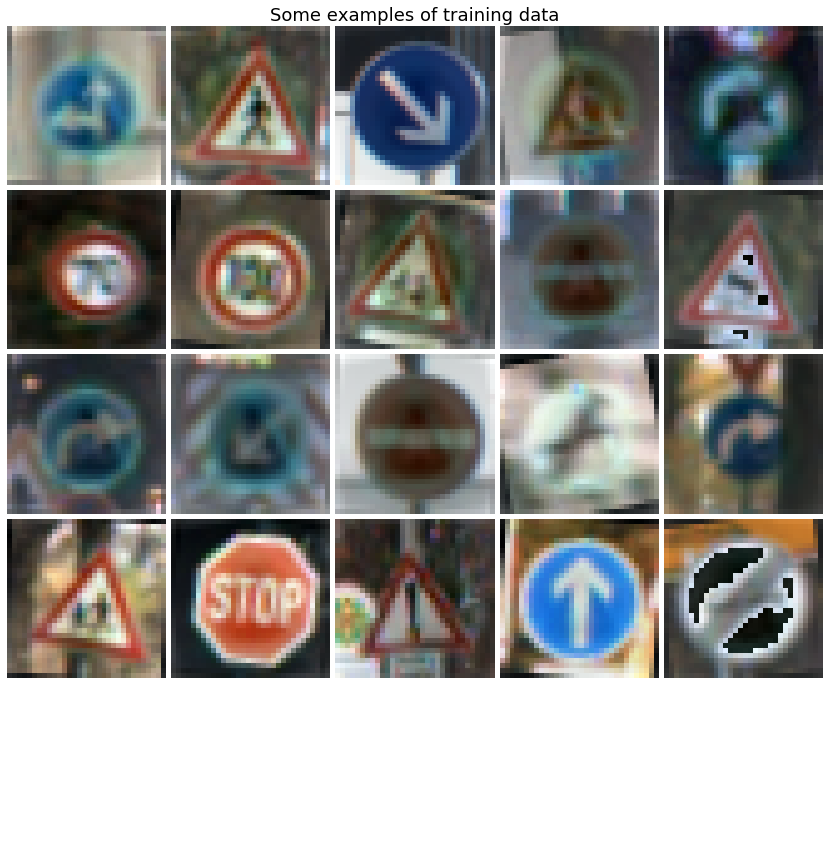

In [7]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:20, :, :, :]
print(examples.shape)  # (20, 32, 32, 3)

# Plotting
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)
plt.show()
plt.close()

# Saving plot
fig.savefig('training_examples.png')
plt.close()

# Random Baseline

In [85]:
match_cnt = 0
y_pred = []
for i in range(len(data['x_test'])):
    x_input = data['x_test'][i:i+1]
    y_input = data['y_test'][i:i+1]

    prediction = random.randint(0, 42)
    
    y_pred.append(prediction)
    
    if y_input[0] == prediction:
        match_cnt+=1

accuracy = match_cnt / len(data['x_test'])

print('Accuracy:', accuracy)

Accuracy: 0.02082343626286619


## confusion matrix

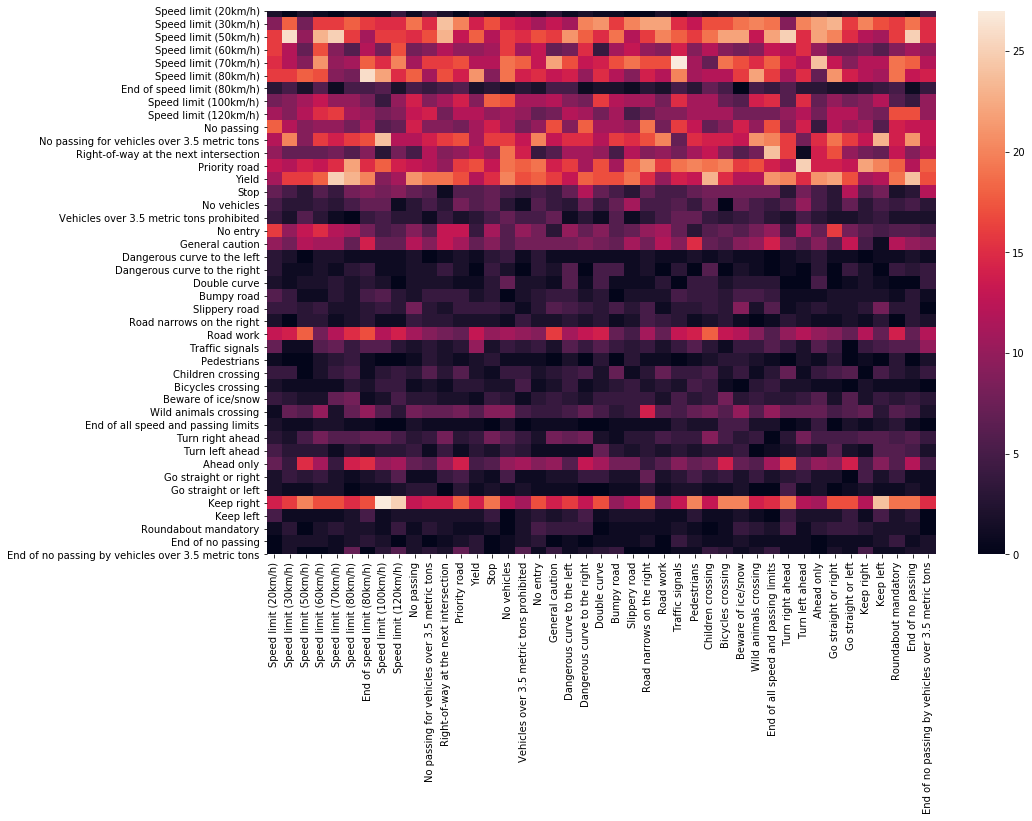

In [88]:
%matplotlib inline
confusion = confusion_matrix(data['y_test'], y_pred)
confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)
plt.figure(figsize = (15,10))
sn.heatmap(confusion_df)

# Baseline CNN model

## Model Setup

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## (Optional) Load model

In [27]:
model_name = "model-17:34:41.477136"
if os.path.exists(model_name):
    model = load_model(model_name)

## Train

In [27]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 15

h = model.fit(data['x_train'], data['y_train'],
              batch_size=5, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)


Train on 86989 samples, validate on 4410 samples
Epoch 1/15
86989/86989 [==============================] - 477s 5ms/step - loss: 0.5248 - accuracy: 0.8638 - val_loss: 0.6858 - val_accuracy: 0.8372
Epoch 2/15
86989/86989 [==============================] - 477s 5ms/step - loss: 0.1153 - accuracy: 0.9689 - val_loss: 0.6801 - val_accuracy: 0.8710
Epoch 3/15
86989/86989 [==============================] - 482s 6ms/step - loss: 0.0689 - accuracy: 0.9820 - val_loss: 0.7335 - val_accuracy: 0.8705
Epoch 4/15
86989/86989 [==============================] - 468s 5ms/step - loss: 0.0465 - accuracy: 0.9877 - val_loss: 0.8993 - val_accuracy: 0.8739
Epoch 5/15
86989/86989 [==============================] - 476s 5ms/step - loss: 0.0359 - accuracy: 0.9904 - val_loss: 0.7417 - val_accuracy: 0.8916
Epoch 6/15
86989/86989 [==============================] - 484s 6ms/step - loss: 0.0272 - accuracy: 0.9925 - val_loss: 0.8244 - val_accuracy: 0.8832
Epoch 7/15
86989/86989 [==============================] - 503s

In [30]:
model_time = datetime.datetime.now().time()
model.save("model-" + str(model_time))

# Test

## One input image

In [23]:
# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


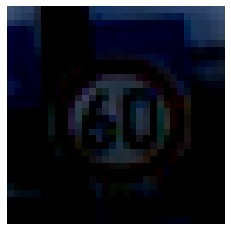

ClassId: 3
Label: Speed limit (60km/h)
True Label: Speed limit (60km/h)


In [30]:
%matplotlib inline

x_input = data['x_test'][100:101]
y_input = data['y_test'][100:101]

# plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')
plt.show()

# Getting scores from forward pass of input image
score = model.predict(x_input)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(score)
print('ClassId:', prediction)

# Getting labels
labels = label_text('data/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])
print('True Label:', labels[y_input[0]])

## All test images

In [31]:
match_cnt = 0
for i in range(len(data['x_test'])):
    x_input = data['x_test'][i:i+1]
    y_input = data['y_test'][i:i+1]

    score = model.predict(x_input)
    prediction = np.argmax(score)
    
    if y_input[0] == prediction:
        match_cnt+=1

accuracy = match_cnt / len(data['x_test'])

print('Accuracy:', accuracy)
    

Accuracy: 0.8878859857482185


# Confusion Matrix

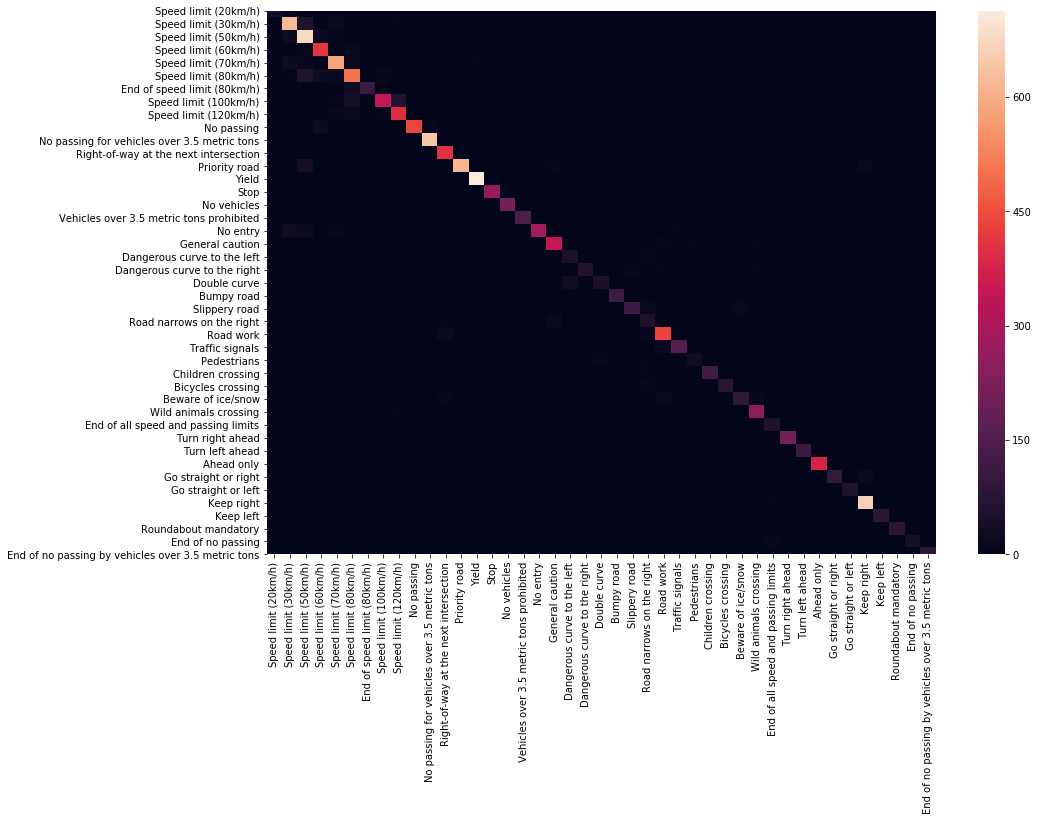

In [82]:
confusion_matrix_gen(model, data['x_test'], data['y_test'])